In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import datetime
import numpy as np
from io import StringIO
from scipy import signal
import json
import matplotlib.animation as animation
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 13
plt.rcParams['animation.html'] = 'html5'

In [5]:
# initial import of data
out = None
filename = 'Backup_03-Feb-2017_15-29.txt'
with open(filename, 'r') as f:
    out = StringIO(f.read().replace(',',';'))
df = pd.read_csv(out, delimiter=';')
df.set_index('Category', inplace=True, drop='True')
df['Time'] = df['Time(millis)']/1000
df['Date'] = [pd.datetime.fromtimestamp(time/1000) for time in df['Date(millis)']]
# still have category, time, date, and scramble

In [6]:
# calculate averages
# regular solves
rdf = df.ix[df.Puzzle=='333'].drop(["Puzzle", 'Scramble', 'Time(millis)', 'Date(millis)', 'Penalty', 'Comment'], axis=1)
rdf = rdf.ix['Normal']
rdf = rdf.set_index('Date')
rdf.sort_index(inplace=True)

In [7]:
ts = np.array(rdf.Time)

mo3 = signal.convolve(ts, np.repeat(1,3), mode='same')/3
mo3 = np.append(np.repeat(np.nan,2), mo3[1:-1])

dom = np.repeat(1,5)
ao5 = (signal.convolve(ts, dom, mode='same') - signal.order_filter(ts, dom, 0) - signal.order_filter(ts, dom, 4))[2:-2]/3
ao5 = np.append(np.repeat(np.nan,4), ao5)

ao12 = np.append(np.repeat(np.nan, 11), signal.convolve(ts, np.repeat(1,12), mode='same')[6:-5])
ao12 -=  np.append(np.repeat(np.nan, 11), np.array([np.max(ts[i-11:i+1]) for i in range(11, len(ao12))]))
ao12 -= np.append(np.repeat(np.nan, 11), np.array([np.min(ts[i-11:i+1]) for i in range(11, len(ao12))]))
ao12 /= 10.

ao50 = np.append(np.repeat(np.nan, 49), signal.convolve(ts, np.repeat(1,50), mode='same')[25:-24])
ao50 -=  np.append(np.repeat(np.nan, 49), np.array([np.sum(np.partition(ts[i-49:i+1], 3)[:3]) for i in range(49, len(ao12))]))
ao50 -=  np.append(np.repeat(np.nan, 49), np.array([np.sum(np.partition(ts[i-49:i+1], 47)[47:]) for i in range(49, len(ao12))]))
ao50 /= 44.

ao100 = np.append(np.repeat(np.nan, 99), signal.convolve(ts, np.repeat(1,100), mode='same')[50:-49])
ao100 -=  np.append(np.repeat(np.nan, 99), np.array([np.sum(np.partition(ts[i-99:i+1], 5)[:5]) for i in range(99, len(ao12))]))
ao100 -=  np.append(np.repeat(np.nan, 99), np.array([np.sum(np.partition(ts[i-99:i+1], 95)[95:]) for i in range(99, len(ao12))]))
ao100 /= 90.

ao1000 = np.append(np.repeat(np.nan, 999), signal.convolve(ts, np.repeat(1,1000), mode='same')[500:-499])/1000.

In [8]:
rdf['mo3']=np.round(mo3,3)
rdf['ao5']=np.round(ao5,3)
rdf['ao12']=np.round(ao12,3)
rdf['ao50']=np.round(ao50,3)
rdf['ao100']=np.round(ao100,3)
rdf['ao1000']=np.round(ao1000,3)

In [9]:
rdf.tail()

,Time,mo3,ao5,ao12,ao50,ao100,ao1000
Date,,,,,,,
2017-02-03 15:23:42.876,16.18,15.220,15.793,15.653,15.649,15.903,16.470
2017-02-03 15:24:11.889,16.74,15.510,15.973,15.736,15.745,15.897,16.473
2017-02-03 15:24:44.139,16.00,16.307,16.017,15.662,15.767,15.904,16.473
2017-02-03 15:25:16.999,16.32,16.353,16.167,15.738,15.759,15.946,16.470
2017-02-03 15:26:24.145,16.21,16.177,16.237,15.907,15.722,15.987,16.471


In [10]:
# daily averages
mindate = rdf.index[0].date()
maxdate = rdf.index[-1].date()
daydf = pd.DataFrame(index=pd.date_range(mindate-datetime.timedelta(days=1),maxdate))

daydf['Average'] = np.zeros(len(daydf))
daydf['Count'] = np.zeros(len(daydf))
for day in daydf.index:
    a = rdf.index==day
    daydf[day, 'Average'] = np.mean(rdf.Time[a])
    daydf[day, 'Count'] = np.count_nonzero(a)


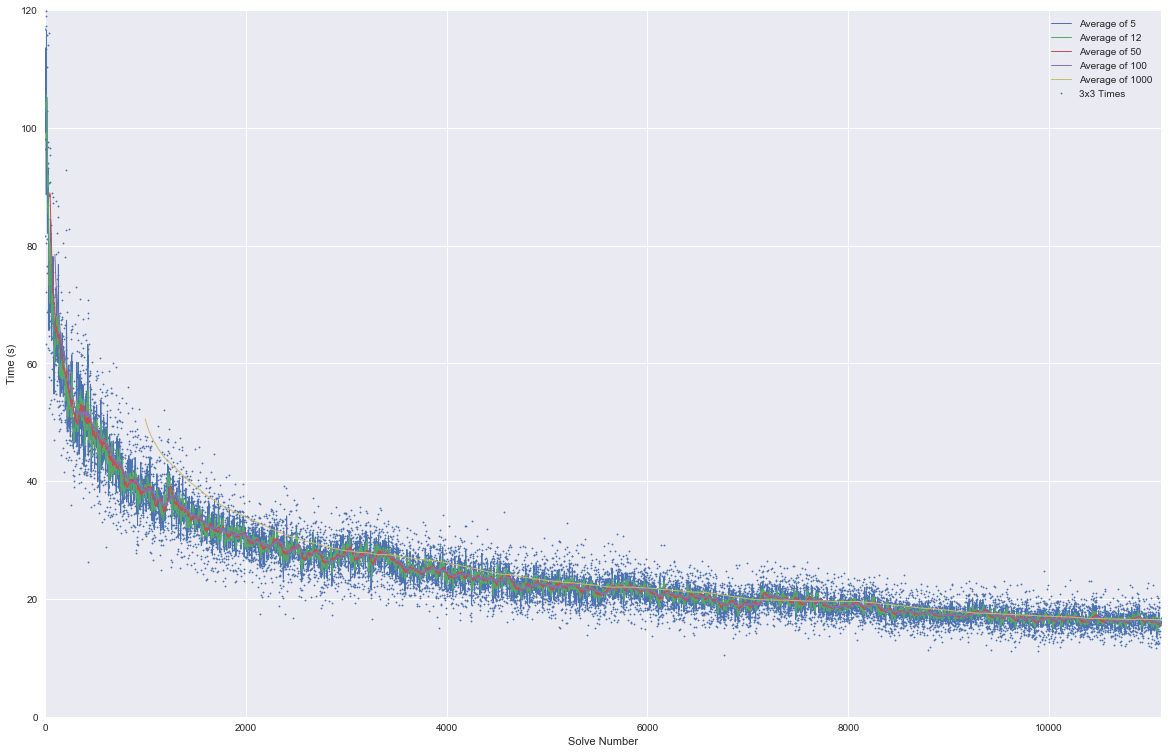

In [11]:
# plot solves
plt.scatter(range(len(rdf)),rdf['Time'], label='3x3 Times', s=2)
plt.plot(range(len(rdf)),rdf.ao5, label='Average of 5', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao12, label='Average of 12', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao50, label='Average of 50', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao100, label='Average of 100', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao1000, label='Average of 1000', linewidth=1)
# plt.xlim(len(rdf)-6000,len(rdf))
plt.xlim(0, len(rdf))
plt.ylim(0,120)
plt.ylabel('Time (s)')
plt.xlabel('Solve Number')
plt.legend(loc='best')

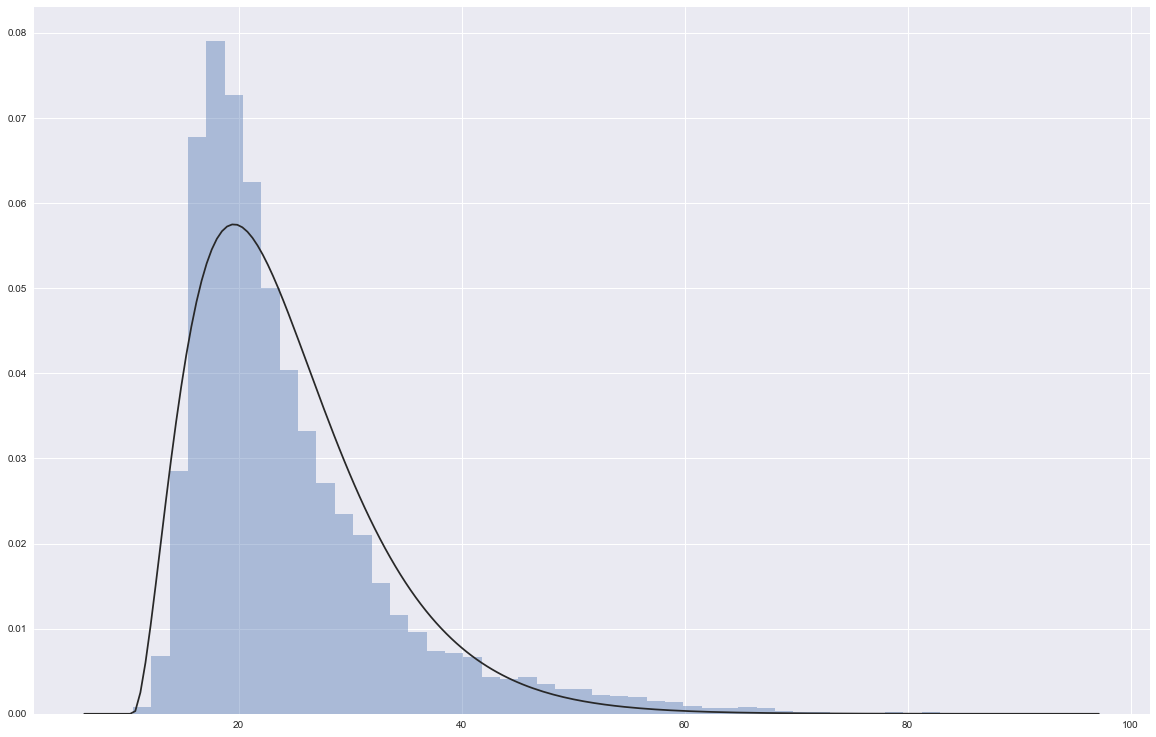

In [12]:
a = np.array(rdf.Time)
sns.distplot(a[100:], fit=stats.gamma, kde=False)

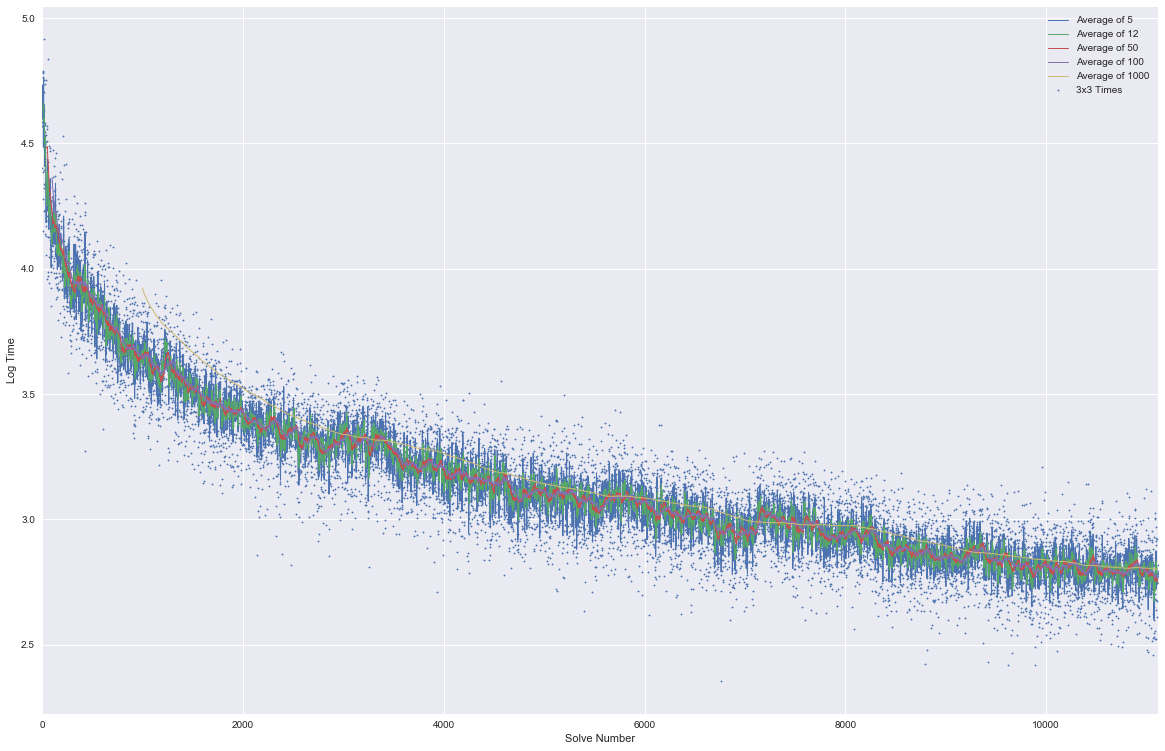

In [13]:
plt.scatter(range(len(rdf)), np.log(rdf['Time']), label='3x3 Times', s=2)
plt.plot(range(len(rdf)), np.log(rdf.ao5), label='Average of 5', linewidth=1)
plt.plot(range(len(rdf)),np.log(rdf.ao12), label='Average of 12', linewidth=1)
plt.plot(range(len(rdf)),np.log(rdf.ao50), label='Average of 50', linewidth=1)
plt.plot(range(len(rdf)),np.log(rdf.ao100), label='Average of 100', linewidth=1)
plt.plot(range(len(rdf)),np.log(rdf.ao1000), label='Average of 1000', linewidth=1)
# plt.xlim(len(rdf)-6000,len(rdf))
plt.xlim(0, len(rdf))
# plt.ylim(0,120)
plt.ylabel('Log Time')
plt.xlabel('Solve Number')
plt.legend(loc='best')

191.8799068927765


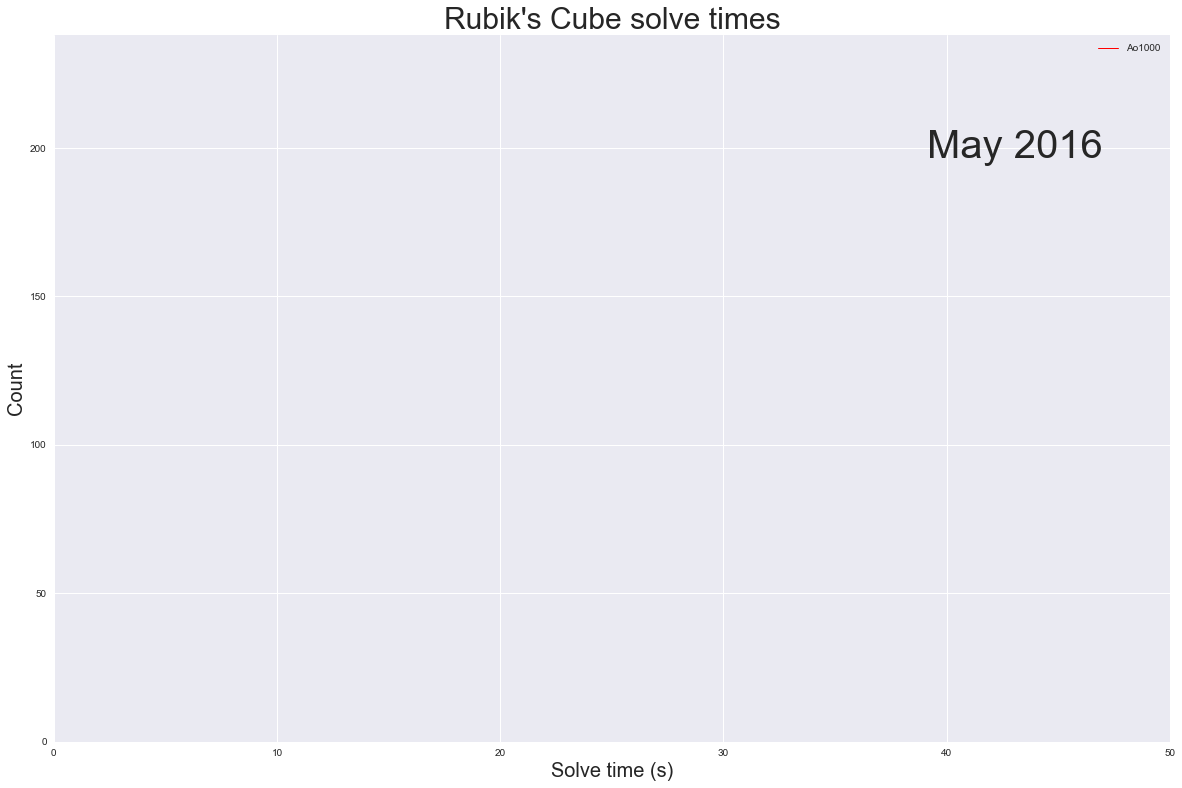

In [34]:
tms = rdf['Time'].values
ao1000 = np.array(rdf.ao1000)
step = 0.25
maxt = 50
n_per_step = 15 # decrease for cleaner animation
start = time.time()

fig, ax = plt.subplots()

bins = np.arange(0,maxt+step,step)
frequencies = np.zeros(len(bins)-1)
rects = ax.bar(bins[:-1], frequencies, 0.25)
avg, = ax.plot([maxt+10*step, maxt+10*step], [0,np.max(np.histogram(tms, bins)[0])+25], 
               color='red', linewidth=1, label='Ao1000')
ax.legend(loc='best')
plt.xlim(0, maxt)
plt.ylim(0, np.max(np.histogram(tms, bins)[0])+25)
plt.xlabel('Solve time (s)', size=20)
plt.ylabel('Count', size=20)
plt.title('Rubik\'s Cube solve times', size=30)


def animate(arg, rs, date_text, average):
    frameno, frequencies, av, new_month = arg
    for rect, f in zip(rs, frequencies):
        rect.set_height(f)
    frame_date = rdf.index[min(int((frameno-0.5)*n_per_step), len(tms)-1)].date()
    date_text.set_text(frame_date.strftime('%B %Y'))
    if av!=np.nan:
        average.set_xdata([av, av])

date_text = ax.text(maxt-3, 200,'matplotlib', horizontalalignment='right', fontsize=40, verticalalignment='center')

interval = int(10*n_per_step/len(tms)*1e3)

def step():
    frequencies = np.zeros(len(bins)-1)
    for frame in np.arange(1, len(tms)//n_per_step+2000//interval):
        min_frame = min(len(tms)-1, (frame-1)*n_per_step)
        max_frame = min(len(tms)-1, frame*n_per_step)
        new_f = np.histogram(tms[min_frame:max_frame], bins)[0]
        frequencies += new_f
        new_month = False
        if rdf.index[min_frame].strftime('%b%Y')!=rdf.index[max_frame-1].strftime('%b%Y'):
            new_month = True
        yield frame, frequencies, ao1000[max_frame-1], new_month

        

ani = animation.FuncAnimation(fig, animate, step, 
                        interval=interval, repeat=False, 
                              blit=False, fargs=(rects,date_text,avg,), save_count=len(tms)//n_per_step+2000//interval)
ani.save('cubehist.mp4') 
end = time.time()
print(end-start)

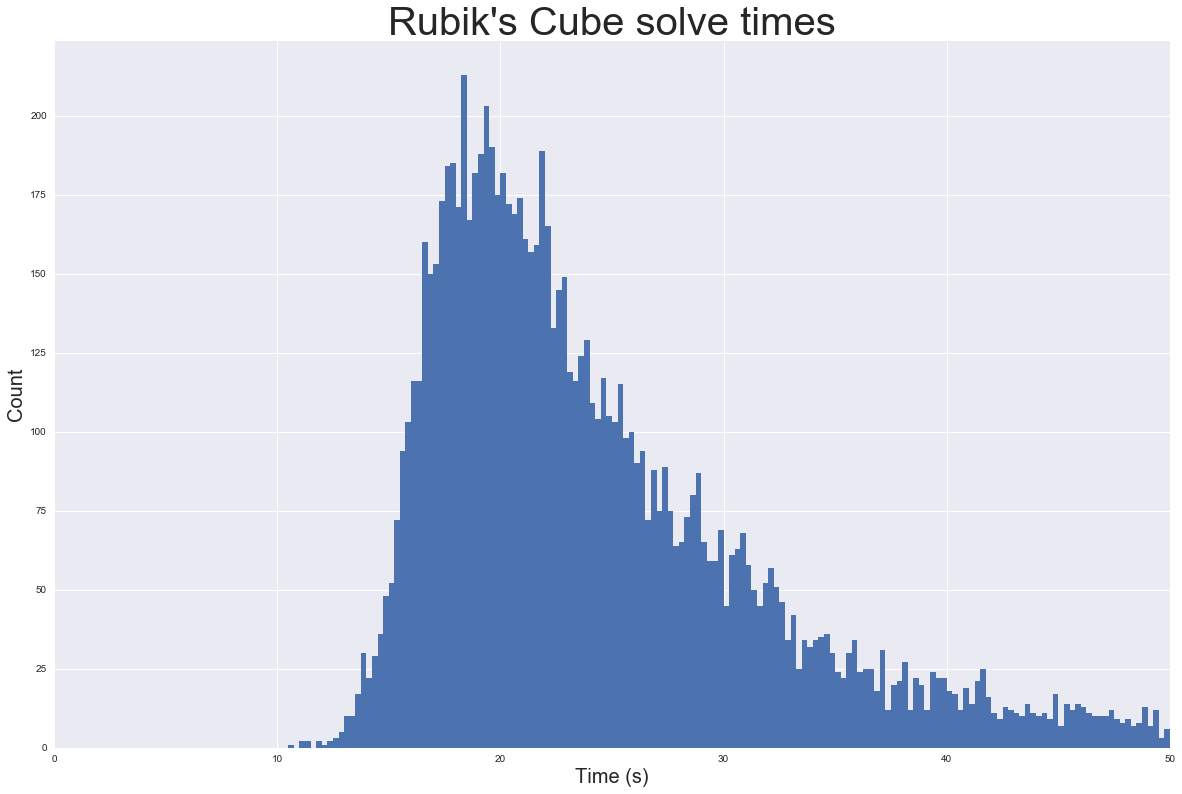

In [64]:
# Histogram of times.  Set range and step to what you want
tms = rdf['Time'].values
step = 0.25
maxt = 50
bins = np.arange(0,maxt+step,step)
plt.hist(tms, bins=bins)
plt.xlim(0,maxt)
plt.xlabel('Time (s)', size=20)
plt.ylabel('Count', size=20)
plt.title('Rubik\'s Cube solve times', size=40)

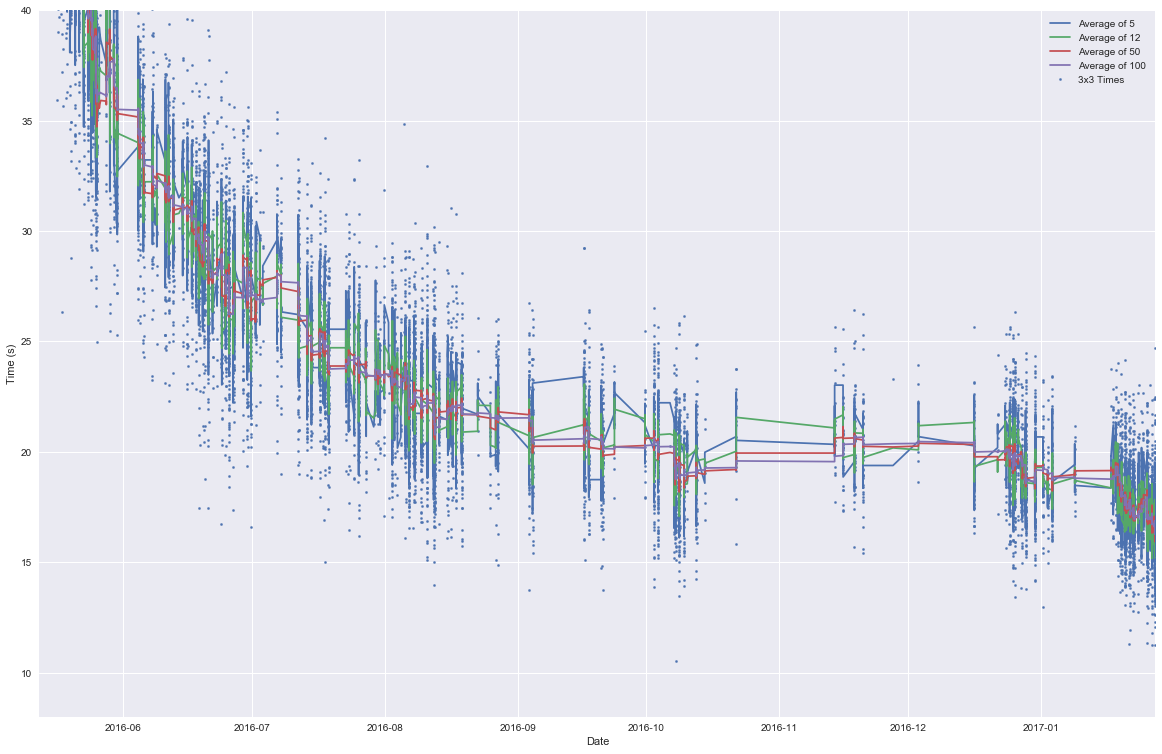

In [138]:
# Plot times vs date.  Set the y range and x range to desired values
plt.scatter(rdf.index,rdf['Time'], label='3x3 Times',s=5)
plt.plot(rdf.ao5, label='Average of 5')
plt.plot(rdf.ao12, label='Average of 12')
plt.plot(rdf.ao50, label='Average of 50')
plt.plot(rdf.ao100, label='Average of 100')
plt.xlim(rdf.index[0],rdf.index[-1]) # x range
plt.ylim(8,40) # y range
plt.ylabel('Time (s)')
plt.xlabel('Date')
plt.legend(loc='best')

In [14]:
# show pbs
print('single: %.3f    '%min(rdf['Time'].dropna()))
print('mo3: %.3f    '%min(rdf.mo3.dropna()))
print('ao5: %.3f    '%min(rdf.ao5.dropna()))
print('ao12: %.3f    '%min(rdf.ao12.dropna()))
print('ao50: %.3f    '%min(rdf.ao50.dropna()))
print('ao100: %.3f    '%min(rdf.ao100.dropna()))
print('ao1000: %.3f    '%min(rdf.ao1000.dropna()))

single: 10.520    
mo3: 13.027    
ao5: 13.473    
ao12: 14.473    
ao50: 15.649    
ao100: 15.897    
ao1000: 16.470    


In [17]:
# show pbs before point
last = 195
print('single: %.3f → %.3f    ' % (min(rdf['Time'][:-last].dropna()), min(rdf['Time'].dropna())))
print('mo3: %.3f → %.3f    ' % (min(rdf.mo3[:-last].dropna()), min(rdf.mo3.dropna())))
print('ao5: %.3f → %.3f    ' % (min(rdf.ao5[:-last].dropna()), min(rdf.ao5.dropna())))
print('ao12: %.3f → %.3f    ' % (min(rdf.ao12[:-last].dropna()), min(rdf.ao12.dropna())))
print('ao50: %.3f → %.3f    ' % (min(rdf.ao50[:-last].dropna()), min(rdf.ao50.dropna())))
print('ao100: %.3f → %.3f    ' % (min(rdf.ao100[:-last].dropna()), min(rdf.ao100.dropna())))
print('ao1000: %.3f → %.3f    ' % (min(rdf.ao1000[:-last].dropna()), min(rdf.ao1000.dropna())))

single: 10.520 → 10.520    
mo3: 13.517 → 13.027    
ao5: 14.073 → 13.473    
ao12: 15.026 → 14.473    
ao50: 15.934 → 15.649    
ao100: 16.115 → 15.897    
ao1000: 16.517 → 16.470    


In [29]:
# count number of solves per day
date_range = pd.date_range(min(df['Date']).date(), max(df['Date']).date())
cdf = pd.DataFrame(index=date_range)
cdf['Count'] = 0
for row in rdf.iterrows():
    cdf.ix[row[1].name.date()] +=1

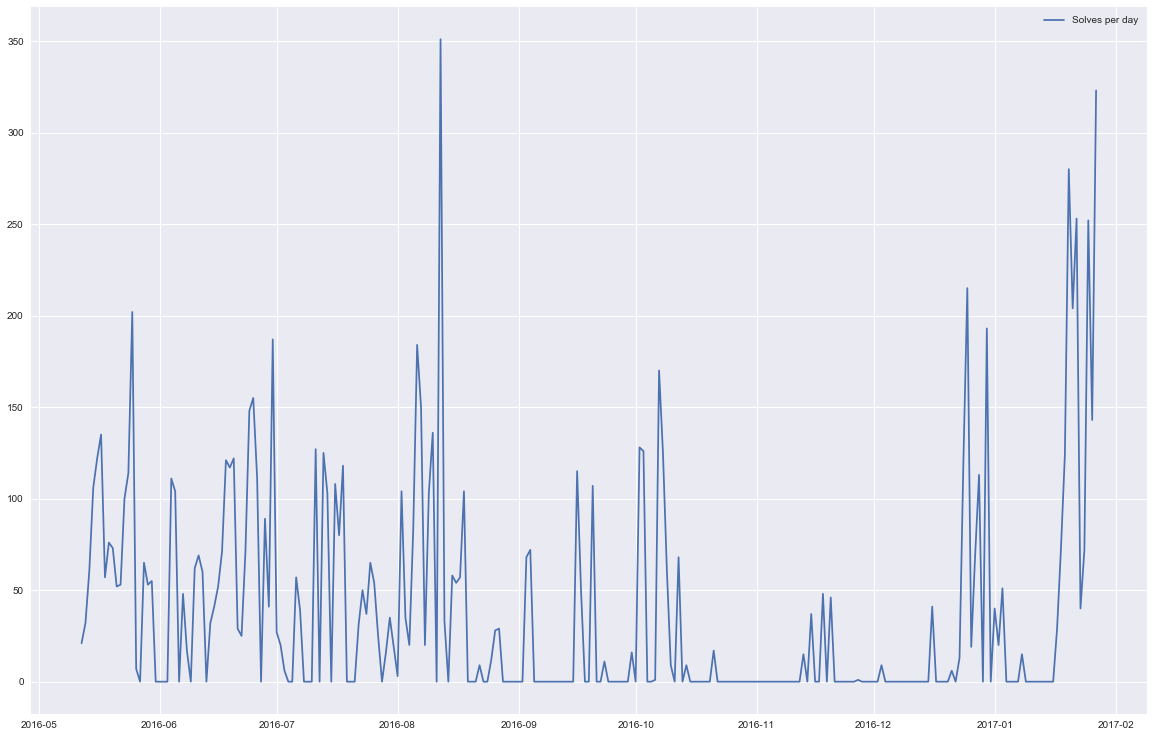

In [30]:
# plot number of solves per day
plt.plot(cdf, label='Solves per day')
plt.legend(loc='best')

In [31]:
# PB Progression calculation
pb = [rdf['Time'][0]]
mo3pb = [rdf.mo3[2]]
ao5pb = [rdf.ao5[4]]
ao12pb = [rdf.ao12[11]]
ao50pb = [rdf.ao50[49]]
ao100pb = [rdf.ao100[99]]
xpb = [[rdf.index[0],1]]
xmo3pb = [[rdf.index[2],3]]
xao5pb = [[rdf.index[4],5]]
xao12pb = [[rdf.index[11],12]]
xao50pb = [[rdf.index[49],50]]
xao100pb = [[rdf.index[99],100]]

i = 0
for row in rdf.iterrows():
    i+=1
    if row[1].Time<pb[-1]:
        pb.append(row[1].Time)
        xpb.append([row[1].name, i])
    if i>2 and row[1].mo3<mo3pb[-1]:
        mo3pb.append(row[1].mo3)
        xmo3pb.append([row[1].name, i])
    if i>4 and row[1].ao5<ao5pb[-1]:
        ao5pb.append(row[1].ao5)
        xao5pb.append([row[1].name, i])
    if i>11 and row[1].ao12<ao12pb[-1]:
        ao12pb.append(row[1].ao12)
        xao12pb.append([row[1].name, i])
    if i>49 and row[1].ao50<ao50pb[-1]:
        ao50pb.append(row[1].ao50)
        xao50pb.append([row[1].name, i])
    if i>99 and row[1].ao100<ao100pb[-1]:
        ao100pb.append(row[1].ao100)
        xao100pb.append([row[1].name, i])    

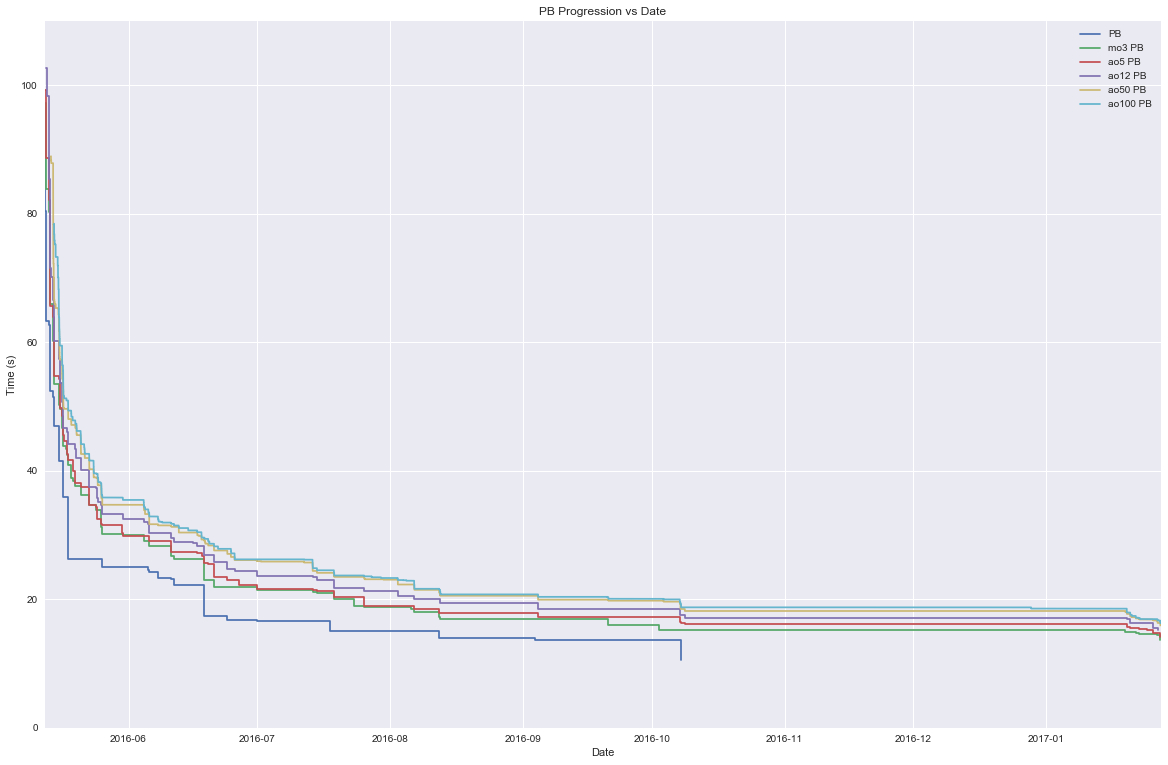

In [144]:
# plot pb progression vs date
xs = [xpb, xmo3pb,xao5pb,xao12pb,xao50pb,xao100pb]
ys = [pb, mo3pb,ao5pb,ao12pb,ao50pb,ao100pb]
labels = ['PB', 'mo3 PB', 'ao5 PB', 'ao12 PB', 'ao50 PB', 'ao100 PB']

for i in range(len(labels)):
    plt.step([j[0] for j in xs[i]], ys[i], label=labels[i], where='post')
plt.xlim(rdf.index[0],rdf.index[-1])
plt.legend(loc='best')
plt.ylim([0,110])
plt.title('PB Progression vs Date')
plt.xlabel('Date')
plt.ylabel('Time (s)')

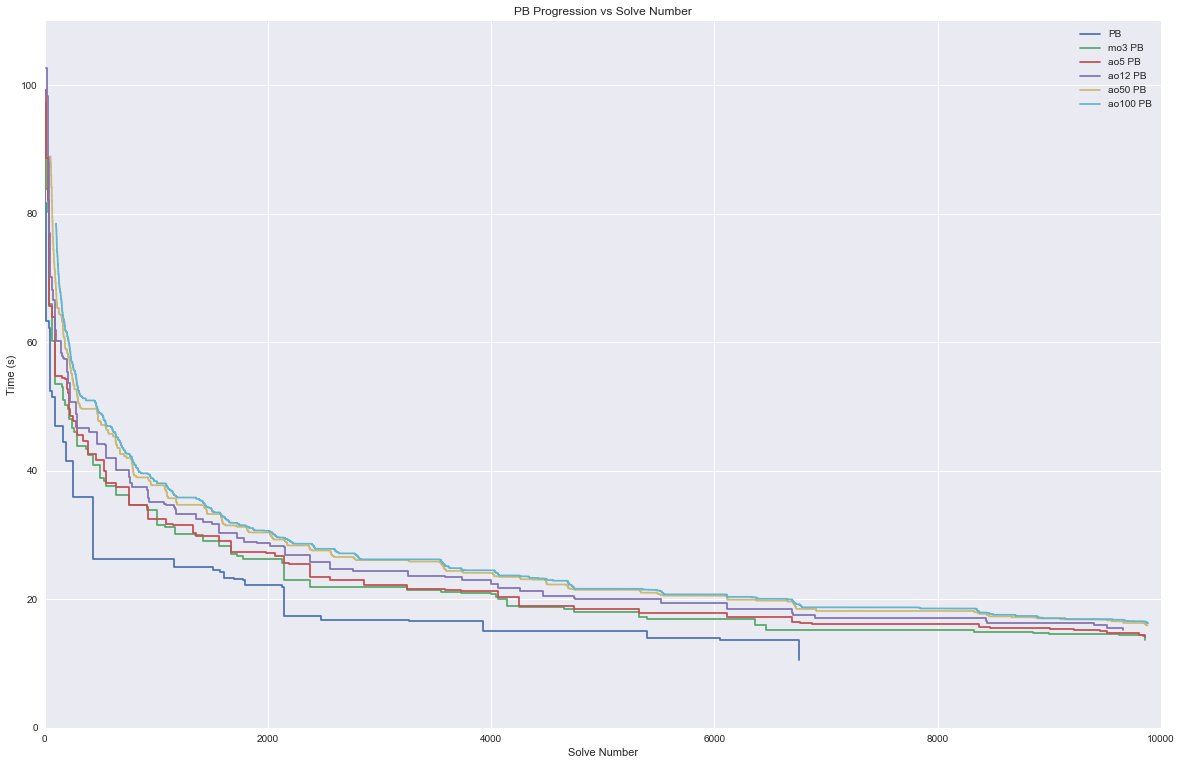

In [145]:
# plot pb progression vs solve num
xs = [xpb, xmo3pb,xao5pb,xao12pb,xao50pb,xao100pb]
ys = [pb, mo3pb,ao5pb,ao12pb,ao50pb,ao100pb]
labels = ['PB', 'mo3 PB', 'ao5 PB', 'ao12 PB', 'ao50 PB', 'ao100 PB']

for i in range(len(labels)):
    plt.step([j[1] for j in xs[i]], ys[i], label=labels[i], where='post')
# plt.xlim(rdf.index[1500],rdf.index[-1])
plt.legend(loc='best')
plt.xlim(0,len(rdf))
plt.ylim([0,110])
plt.title('PB Progression vs Solve Number')
plt.xlabel('Solve Number')
plt.ylabel('Time (s)')

In [6]:
# nothing fancy, just basic cstimer times import
fn = 'cstimer.txt'
with open(fn) as f:
    data = json.load(f)
times = []
scrambles = []
for sessionname in data.keys():
    if sessionname!='properties':
        j1 = json.loads(data[sessionname])
        for solve in j1:
            times.append(solve[0][1]/1000.0)
            scrambles.append(solve[1])

In [24]:
def cstimerimport(filename):
    with open(filename) as f:
        data = json.load(f)
    times = []
    scrambles = []
    for sessionname in data.keys():
        if sessionname!='properties':
            j1 = json.loads(data[sessionname])
            for solve in j1:
                times.append(solve[0][1]/1000.0)
                scrambles.append(solve[1])

# This should be changed to the method used above
def listtodf(timelist):
    rdf = pd.DataFrame(timelist, columns=['Time'])
    for i in range(len(rdf['Time'])):
        if i<2:
            pass
        if i>=2:
            rdf.set_value(rdf.index[i], 'mo3', round(sum(rdf['Time'][i-2:i+1])/3.0,3))
        if i>=4:
            tmp=rdf['Time'][i-4:i+1]
            rdf.set_value(rdf.index[i], 'ao5', round(sum(tmp.sort_values()[1:-1])/3.0,3))
            rdf.set_value(rdf.index[i], 'sd5', round(np.std(tmp),3))
        if i>=11:
            tmp=rdf['Time'][i-11:i+1]
            rdf.set_value(rdf.index[i], 'ao12', round(sum(tmp.sort_values()[1:-1])/10.0,3))
            rdf.set_value(rdf.index[i], 'sd12', round(np.std(tmp),3))
        if i>=49:
            tmp = rdf['Time'][i-49:i+1]
            rdf.set_value(rdf.index[i], 'ao50', round(sum(tmp.sort_values()[3:-3])/44.0,3))
            rdf.set_value(rdf.index[i], 'sd50', round(np.std(tmp),3))

        if i>=99:
            tmp = rdf['Time'][i-99:i+1]
            rdf.set_value(rdf.index[i], 'ao100', round(sum(tmp.sort_values()[5:-5])/90.0,3))
            rdf.set_value(rdf.index[i], 'sd100', round(np.std(tmp),3))

        if i>=999:
            tmp = rdf['Time'][i-999:i+1]
            rdf.set_value(rdf.index[i], 'ao1000', round(sum(tmp.sort_values()[50:-50])/900.0,3))
            rdf.set_value(rdf.index[i], 'sd1000', round(np.std(tmp),3))
    return rdf

In [42]:
dates = (np.array(rdf.index).astype(np.int64)/1e9).astype(np.int64)
solves = (np.array(rdf.Time)*1000).astype(np.int64)
full = np.append(dates, solves).reshape(2,-1).T
np.savetxt('times.csv', full, delimiter=',')

1131.89852809906


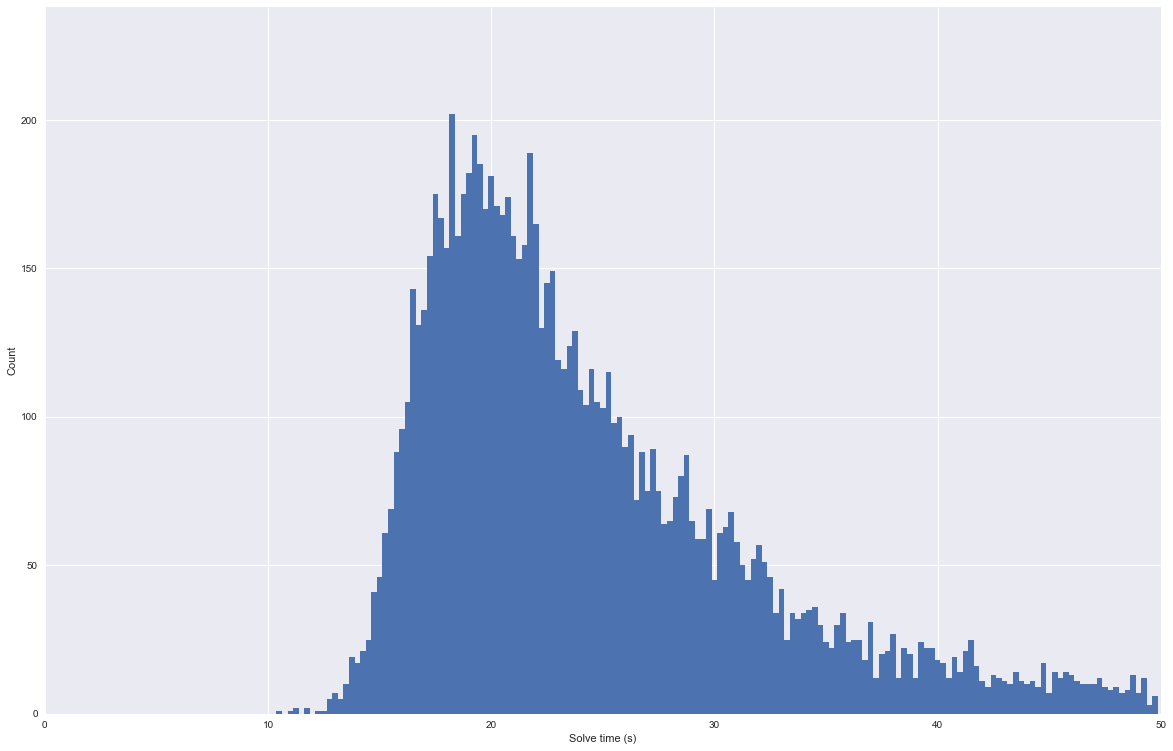

In [209]:
# anim vs date
start = time.time()
tms = pd.Series(rdf.Time)
step = 0.25
maxt = 50

fig, ax = plt.subplots()

bins = np.arange(0,maxt+step,step)
frequencies = np.zeros(len(bins)-1)
rects = ax.bar(bins[:-1], frequencies, 0.25)

plt.xlim(0, maxt)
plt.ylim(0, np.max(np.histogram(tms, bins)[0])+25)
plt.xlabel('Solve time (s)')
plt.ylabel('Count')

def animate(arg, rects):
    frameno, frequencies, changed = arg
    if changed:
        for rect, f in zip(rects, frequencies):
            rect.set_height(f)

mindate = rdf.index[0].date()
maxdate = rdf.index[-1].date()
nframes = len(pd.date_range(mindate,maxdate, freq='6h'))

def step():
    frequencies = np.zeros(len(bins)-1)
    mindate = rdf.index[0].date()
    maxdate = rdf.index[-1].date()
    range_to_plot = pd.date_range(mindate,maxdate, freq='6h')
    for frame in range_to_plot:
        mask = (tms.index > frame) & (tms.index <= frame+datetime.timedelta(hours=6))
        d_frequecies = np.histogram(tms.loc[mask], bins)[0]
        frequencies += d_frequecies
        changed = True
        if (d_frequecies==0).all():
            changed = False
        yield frame, frequencies, changed

date_ani = animation.FuncAnimation(fig, animate, step, 
                        interval=4, repeat=False, 
                              blit=False, fargs=(rects,), save_count=nframes)
date_ani.save('test.mp4') 
end = time.time()
print(end-start)